# Try to align Subj01 from BOLD5000 to NSD

In [5]:
import os
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import warnings
import numpy as np
from sklearn.linear_model import RidgeCV
import numpy as np
import torch
from os.path import join as opj
from transformers import AutoProcessor, CLIPTextModel
import tqdm
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
%matplotlib inline
from os import makedirs
import matplotlib.pyplot as plt


## Step 0 find the same images

In [6]:
## load source and target data

# load target data
target_idx=1


target_train_imgs=f"/home/matteo/data/NSD/processed_roi/subj0{target_idx}/MNI/nsd_train_stim_sub{target_idx}.npy"
target_test_imgs=f"/home/matteo/data/NSD/processed_roi/subj0{target_idx}/MNI/nsd_test_stim_sub{target_idx}.npy"


In [7]:
target_train_imgs=np.load(target_train_imgs)
target_test_imgs=np.load(target_test_imgs)


In [8]:
#concatenate train and test
target_imgs=np.concatenate((target_train_imgs,target_test_imgs),axis=0)


In [9]:
## load source common images
subj="CSI1"
base_path=opj("/home/matteo/data/BOLD5000/Processed_dilated",subj)

source_common_imgs=np.load(opj(base_path,f"y_align_{subj}.npy"))


In [10]:
import numpy as np
import torch
import torchvision.transforms as transforms
import torchvision.models as models
from sklearn.neighbors import NearestNeighbors
from PIL import Image

# Load and preprocess your image data
# images_1 and images_2 are your arrays of images

# Load a pre-trained ResNet model
model = models.resnet50(pretrained=True)
model.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Preprocessing for ResNet
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Function to extract image features using the pre-trained model
def extract_features(images, batch_size=32):
    features = []
    num_images = len(images)
    
    for i in tqdm.trange(0, num_images, batch_size):
        batch_images = images[i:i + batch_size]
        batch_tensors = [preprocess(Image.fromarray(img)).to(device) for img in batch_images]
        batch_tensors = torch.stack(batch_tensors)
        
        with torch.no_grad():
            batch_features = model(batch_tensors).view(batch_tensors.size(0), -1).cpu().numpy()
        
        features.extend(batch_features)
    
    return np.array(features)

# Extract image features
features_target = extract_features(target_imgs.astype(np.uint8))
features_source = extract_features(source_common_imgs)

# Build an index for the first set of features using NearestNeighbors
index = NearestNeighbors(n_neighbors=1, algorithm='auto').fit(features_target)

# Find nearest neighbors for features in the second array
distances, indices = index.kneighbors(features_source)

# Indices now contain the indices of matching images in the first array
matching_indices = indices.flatten()


/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/matteo/anaconda3/envs/deep/lib/python3.9/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
100%|██████████| 37/37 [00:04<00:00,  8.22it/s]


In [25]:
matching_indices.shape

#lavorare qua check images are the same

(1181,)

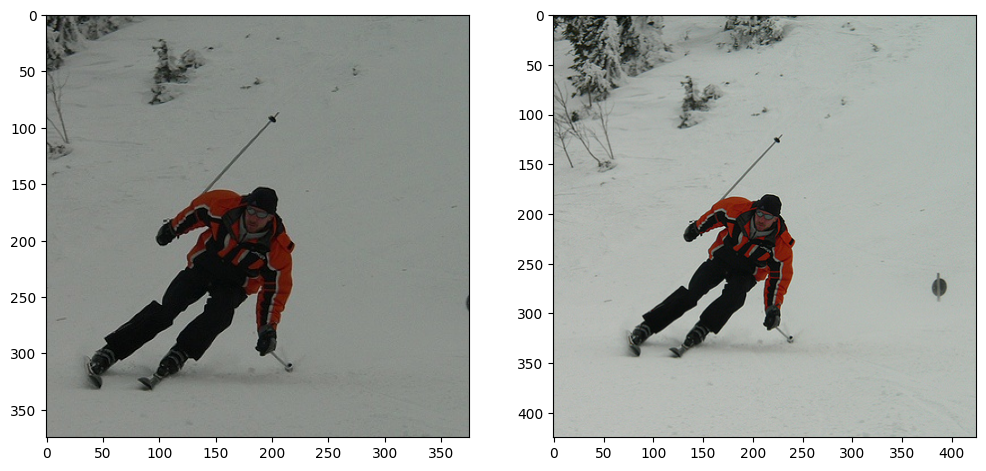

In [30]:
fig, axs=plt.subplots(1,2,figsize=(12,6))
idx=18
axs[0].imshow(source_common_imgs[idx])
axs[1].imshow(target_imgs[matching_indices[idx]].astype(np.uint8))


In [31]:
target_common_imgs=target_imgs[matching_indices]


In [40]:
# matching_indices.max()

source_common_fmri=np.load(opj(base_path,f"x_align_{subj}.npy"))

fmri_target_train_data=f"/home/matteo/data/NSD/processed_roi/subj0{target_idx}/MNI/nsd_train_fmriavg_nsdgeneral_sub{target_idx}.npy"
fmri_target_test_data=f"/home/matteo/data/NSD/processed_roi/subj0{target_idx}/MNI/nsd_test_fmriavg_nsdgeneral_sub{target_idx}.npy"

fmri_target_data=np.concatenate((np.load(fmri_target_train_data),np.load(fmri_target_test_data)),axis=0)

target_common_fmri=fmri_target_data[matching_indices]

source_train_fmri=np.load(opj(base_path,f"x_train_{subj}.npy"))
source_test_fmri=np.load(opj(base_path,f"x_test_{subj}.npy"))


In [51]:
aligner=RidgeCV(alphas=[1e2,1e3,1e4,5e4], fit_intercept=True)
aligner.fit(source_common_fmri,target_common_fmri)

aligned_source_test=aligner.predict(source_test_fmri)
aligned_source_train=aligner.predict(source_train_fmri)
aligned_source_comparison=aligner.predict(source_common_fmri)

#adjust values
final_mean=target_common_fmri.mean(0)
final_std=target_common_fmri.std(0)


aligned_source_test_adj=(aligned_source_test-aligned_source_test.mean(0))/(1e-8+aligned_source_test.std(0))
aligned_source_test_adj=final_std*aligned_source_test_adj+final_mean

aligned_source_train_adj=(aligned_source_train-aligned_source_train.mean(0))/(1e-8+aligned_source_train.std(0))
aligned_source_train_adj=final_std*aligned_source_train_adj+final_mean

aligned_source_comparison_adj=(aligned_source_comparison-aligned_source_test.mean(0))/(1e-8+aligned_source_test.std(0))
aligned_source_comparison_adj=final_std*aligned_source_comparison_adj+final_mean

In [52]:
## save all data
outdir=opj("bold5000_aligned",subj)
os.makedirs(outdir,exist_ok=True)

np.save(opj(outdir,"aligned_source_test.npy"),aligned_source_test_adj)
np.save(opj(outdir,"aligned_source_train.npy"),aligned_source_train_adj)
np.save(opj(outdir,"aligned_source_comparison.npy"),aligned_source_comparison_adj)



In [46]:
## save also all images and captions

source_train_imgs=np.load(opj(base_path,f"y_train_{subj}.npy"))
source_test_imgs=np.load(opj(base_path,f"y_test_{subj}.npy"))

np.save(opj(outdir,"y_train.npy"),source_train_imgs)
np.save(opj(outdir,"y_test.npy"),source_test_imgs)
np.save(opj(outdir,"y_align.npy"),source_common_imgs)

# load captions

train_captions=np.load(opj(base_path,f"train_captions_{subj}.npy"))
test_captions=np.load(opj(base_path,f"test_captions_{subj}.npy"))
align_caption=np.load(opj(base_path,f"align_captions_{subj}.npy"))

#save them
np.save(opj(outdir,"train_captions.npy"),train_captions)
np.save(opj(outdir,"test_captions.npy"),test_captions)
np.save(opj(outdir,"align_captions.npy"),align_caption)



In [50]:
source_test_imgs.shape, aligned_source_test_adj.shape, aligned_source_comparison_adj.shape, aligned_source_train_adj.shape

((411, 375, 375, 3), (3696, 14197), (1181, 14197), (3696, 14197))